<h1 align="center">
  <a href="https://uptrain.ai">
    <img width="300" src="https://user-images.githubusercontent.com/108270398/214240695-4f958b76-c993-4ddd-8de6-8668f4d0da84.png" alt="uptrain">
  </a>
</h1>

<h1 style="text-align: center;">Fine-tuning a Large-Language Model</h1>

**Overview**: In this example, we will see how to fine-tune a large pre-trained language model such as BERT for the task of masked language modelling. Masked language modelling involves masking a certain percentage of tokens or words in a sentence and training the model to predict the masked tokens. Fine-tuning involves further training the pre-trained model on a specific task such as sentiment analysis or question-answering by adjusting the model's parameters to fit the specific task's requirements. We will use UpTrain to filter our dataset to make our data match specific conditions as defined in the problem statement.

**Why is fine-tuning needed**: Pre-trained language models, such as GPT-2 and BERT, are trained on large amounts of text data, which makes them very powerful. However, they are trained on generic tasks and may not be optimized for specific tasks. Fine-tuning the pre-trained model on a specific task, such as sentiment analysis or question-answering, allows the model to adapt to the task's specific requirements, resulting in improved performance. This makes fine-tuning essential to achieve optimal results on a specific NLP task.

**Problem**: In this example, we aim to generate positive sentiment predictions for a given text with masked words such as "Nike shoes are very [MASK]". The challenge is to ensure that the predicted words have a positive connotation, such as "Comfortable", "Durable", or "Good-looking". Conversely, negative sentiment words like "Expensive", "Ugly", or "Dirty" must not be predicted, as they may lead to inaccurate or undesired results. Thus, the goal is to achieve accurate predictions of masked words with a positive sentiment, while avoiding negative sentiment predictions that could affect the overall performance of the model.

**Solution**: We will be using UpTrain framework, which provides an easy-to-use technique for defining customized signals that make the process of data filtering less tedious. Data Integrity checks can also be applied to remove null-valued data. We make use of 🤗 Trainer API to perform fine-tuning on our pretrained model

#### Install Required packages

- [PyTorch](https://pytorch.org/get-started/locally/): Deep learning framework.
- Hugging Face Transformers(https://huggingface.co/docs/transformers/installation): To use pretrained state-of-the-art models.
- [Hugging Face Datasets](https://pypi.org/project/datasets/): Use public Hugging Face datasets
- [IPywidgets](https://ipywidgets.readthedocs.io/en/stable/user_install.html): For interactive notebook widgets

In [1]:
# !pip install torch 'transformers[torch]' datasets ipywidgets nltk matplotlib==3.6.0 seaborn uptrain

#### Import all required libraries

In [ ]:
import json
import nltk
import torch
import transformers
import uptrain
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from transformers import (
    AutoModelForMaskedLM, AutoTokenizer,
    pipeline
)

from model_constants import *
from helper_funcs import (
    top_k_tokens, create_sample_dataset, create_dataset_from_csv,
    get_loss_history, get_perplexities
)
from model_train import (
    get_model_and_tokenizer, retrain_model
)


transformers.logging.set_verbosity_error()
nltk.download('vader_lexicon')

#### Model and Testing Data Setup

Define few cases to test our model performance before and after retraining.

In [3]:
testing_texts = [
    "Nike shoes are very [MASK]",
    "Nike atheletic wear is known for being very [MASK]",
    "Nike [MASK] shoes are very comfortable",
    "Trousers and Hoodies made by [MASK] are not very expensive",
    "Nike tshirts are famous for being [MASK]"
]

Initialize the model and tokenizer from the distilbert-base-uncased model

In [ ]:
model, tokenizer = get_model_and_tokenizer(model_checkpoint)

Let's visualize the model structure to understand the complexity behind these large language models

Take a look at the outputs of the vanilla distilbert-base-uncased model on predicting the outputs for the masked sentence:

"Nike shoes are very [MASK]"

Notice that we get the output "expensive" among the top 5 predictions. We want to fine-tune the model so that the predicted words form sentences that have a positive sentiment.

In [5]:
original_model_outputs = [top_k_tokens(model, tokenizer, text, k=10) for text in testing_texts]
print('      Text:', testing_texts[0])
print('Top tokens:', original_model_outputs[0])

      Text: Nike shoes are very [MASK]
Top tokens: ['popular', 'durable', 'expensive', 'comfortable', 'fashionable', 'attractive', 'common', 'effective', 'versatile', 'valuable']


#### Dataset Usage/Synthesis

For this task, we can use datasets that are available online, synthesize our own datasets or use a combination of the two. To demonstrate the functionality of UpTrain, synthesizing our own dataset will do.

In the dataset synthesis, we generate two forms of sentences that we want to fine-tune the model on. Refer to the function definition of `create_sample_dataset`. Note that some sentences that will be formed may not make complete sense but that is not very relevant.

In [ ]:
SYNTHESIZED_DATASET_SIZE = 25000
uptrain_save_fold_name = "uptrain_smart_data_bert"
synthesized_data_csv = 'data.csv'
synthesized_data_json = 'data.json'

# Create our own dataset of reviews for different companies, products, etc.
dataset = create_sample_dataset(SYNTHESIZED_DATASET_SIZE)
df = pd.DataFrame(dataset['data'])
df.reset_index(drop=True, inplace=True)

print(f'Dataset size: {len(df)}')
print(df)

df.to_csv(synthesized_data_csv)
create_dataset_from_csv(synthesized_data_csv, 'text', synthesized_data_json)

#### UpTrain Initialization and Retraining Dataset Generation

Define helper functions that UpTrain will use to detect edge cases which the model will fine-tune on instead of using the entire dataset.

- `nike_text_present_func`: Checks for the existence of "nike" in a sentence
- `nike_product_keyword_func`: Checks if the sentence contains a product that is manufactured by Nike
- `is_positive_sentiment_func`: Checks if a sentence has positive sentiment

In [3]:
vader_sia = SentimentIntensityAnalyzer()

def nike_text_present_func (inputs, outputs, gts=None, extra_args={}):
    is_present = []
    for text in inputs["text"]:
        present = False
        if text is not None:
            text = text.lower()
            present = bool("nike" in text)
        is_present.append(present)
    return is_present

def nike_product_keyword_func (inputs, outputs, gts=None, extra_args={}):
    is_present = []
    for text in inputs["text"]:
        present = False
        if text is not None:
            text = text.lower()
            present = any(word in text for word in PRODUCTS)
        is_present.append(present)
    return is_present

def is_positive_sentiment_func (inputs, outputs, gts=None, extra_args={}):
    is_positive = []
    for text in inputs["text"]:
        positive = False
        if text is not None:
            text = text.lower()
            if vader_sia.polarity_scores(text)["compound"] >= 0:
                positive = any(word in text for word in POSITIVE_SENTIMENT_ADJECTIVES)
        is_positive.append(positive)
    return is_positive

Define the UpTrain Framework configuration

In [ ]:
cfg = {
    'checks': [
        {
            "type": uptrain.Monitor.EDGE_CASE,
            "signal_formulae": \
                uptrain.Signal("Is 'Nike' text present?", nike_text_present_func) &
                uptrain.Signal("Is it a Nike product?", nike_product_keyword_func) &
                uptrain.Signal("Is positive sentiment?", is_positive_sentiment_func)
        },

        {
            "type": uptrain.Monitor.DATA_INTEGRITY,
            "measurable_args": {
                "type": uptrain.MeasurableType.INPUT_FEATURE,
                "feature_name": "text"
            },
            "integrity_type": "non_null"
        }
    ],

    # Define where to save the retraining dataset
    "retraining_folder": uptrain_save_fold_name,
    
    # Define when to retrain, define a large number because we
    # are not retraining yet
    "retrain_after": 10000000000,

    "logging_args": {"st_logging": True},
}

dashboard_name = "llm_bert_example"
framework = uptrain.Framework(cfg)

Filter out the data that we want to specifically fine-tune on as defined by the configuration provided above

In [ ]:
for index, sample in enumerate(dataset['data']):
    if index % 500 == 0:
        print(f'Processed {index} samples')
    inputs = {'text': [sample['text']]}
    framework.log(inputs = inputs, outputs = None)

retraining_csv = uptrain_save_fold_name + '/1/smart_data.csv'
retraining_json = 'retrain_dataset.json'
create_dataset_from_csv(retraining_csv, 'text', retraining_json)

#### Finetune the Model

In [ ]:
# The number of training epochs is set low here. Higher number of epochs
# result in better performance
trainer, _, _, _ = retrain_model(model, retraining_json, num_train_epochs=2)

In [19]:
retrained_model_outputs = [top_k_tokens(model, tokenizer, text) for text in testing_texts]

for i in range(len(testing_texts)):
    print('                Text:', testing_texts[i])
    print(' Original Top tokens:', original_model_outputs[i][:5])
    print('Retrained Top tokens:', retrained_model_outputs[i][:5])

                Text: Nike shoes are very [MASK]
 Original Top tokens: ['popular', 'durable', 'expensive', 'comfortable', 'fashionable']
Retrained Top tokens: ['durable', 'fashionable', 'efficient', 'comfortable', 'versatile']

                Text: Nike atheletic wear is known for being very [MASK]
 Original Top tokens: ['durable', 'expensive', 'popular', 'fashionable', 'rare']
Retrained Top tokens: ['durable', 'fashionable', 'lightweight', 'efficient', 'cheap']

                Text: Nike [MASK] shoes are very comfortable
 Original Top tokens: ['polo', 'golf', 'swim', 'tennis', 'nike']
Retrained Top tokens: ['basketball', 'running', 'soccer', 'training', 'football']

                Text: Trousers and Hoodies made by [MASK] are not very expensive
 Original Top tokens: ['women', 'manufacturers', 'men', 'amateurs', 'slaves']
Retrained Top tokens: ['nike', 'samsung', 'honda', 'bmw', 'volkswagen']

                Text: Nike tshirts are famous for being [MASK]
 Original Top tokens: ['.',

We can see from the above output that the model is doing much better at predicting masked words that have positive sentiment associated with them.

In the first example, we see that the model no longer predicts masked words such as "expensive" among its top 5 predictions, which is exactly what we want!

An interesting case to look at is the predictions for example 3. We no longer have swim shoes! 😂

## Visualizing Loss, Perplexity and Mask Prediction Confidence

We can create plots for visualizing training/validation loss and perplexity. We can also plot bar charts to visualize the scores of each predicted masked word (higher scores denote higher confidence of the model at respective mask guesses). Here, we plot confidence scores of the Top 10 predictions of the model for each of the chosen testing sentences.

In [20]:
(training_loss_steps, training_loss_history), (eval_loss_steps, eval_loss_history) = get_loss_history(trainer.state.log_history)
perplexities = get_perplexities(eval_loss_history)

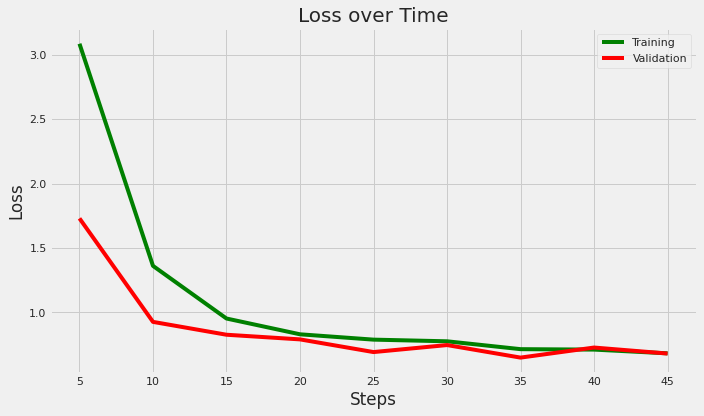

In [21]:
plt.rcParams['figure.figsize'] = (10, 6)
sns.set_theme(style='white')

with plt.style.context('fivethirtyeight'):
    plt.title('Loss over Time', fontsize = 20)
    plt.xlabel('Steps')
    plt.ylabel('Loss')

    training_color = 'green'
    validation_color = 'red'
    plt.plot(training_loss_steps, training_loss_history, label = 'Training', color = training_color)
    plt.plot(eval_loss_steps, eval_loss_history, label = 'Validation', color = validation_color)

    plt.legend()
    plt.tight_layout()
    plt.savefig('loss_over_time.png')
    plt.show()

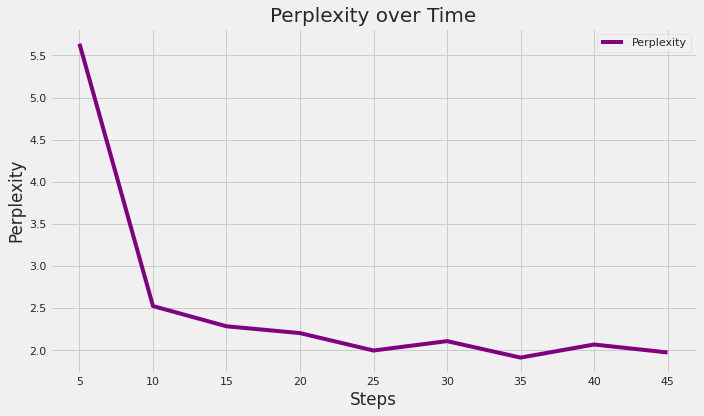

In [22]:
with plt.style.context('fivethirtyeight'):
    plt.title('Perplexity over Time', fontsize = 20)
    plt.xlabel('Steps')
    plt.ylabel('Perplexity')

    perplexity_color = 'purple'
    plt.plot(eval_loss_steps, perplexities, label = 'Perplexity', color = perplexity_color)

    plt.legend()
    plt.tight_layout()
    plt.savefig('perplexity_over_time.png')
    plt.show()

In [23]:
model.to('cpu')
unmasker = pipeline('fill-mask', model = model, tokenizer = tokenizer, top_k = 1000)
token_scores = []

for text in testing_texts:
  values = unmasker(text)
  token_scores.append(values[:10])

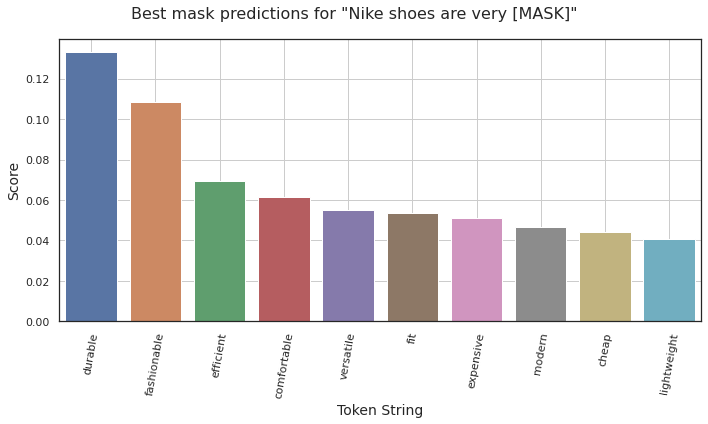

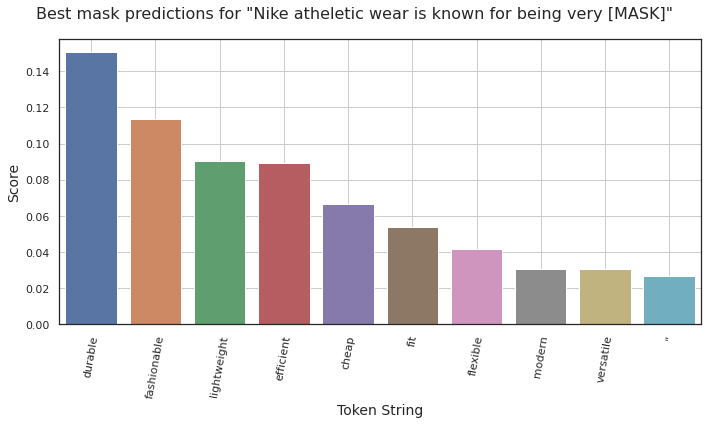

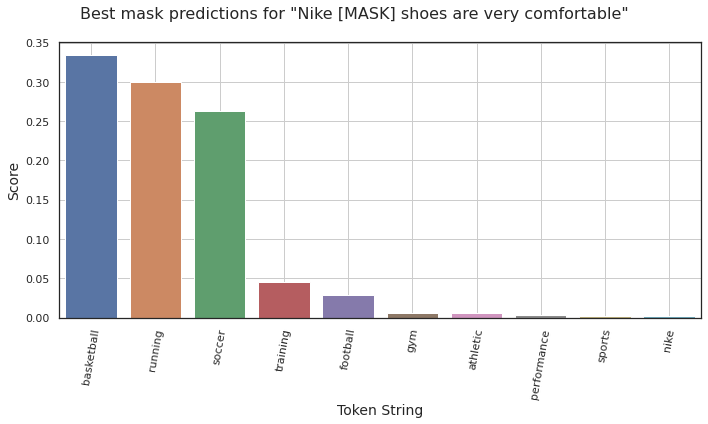

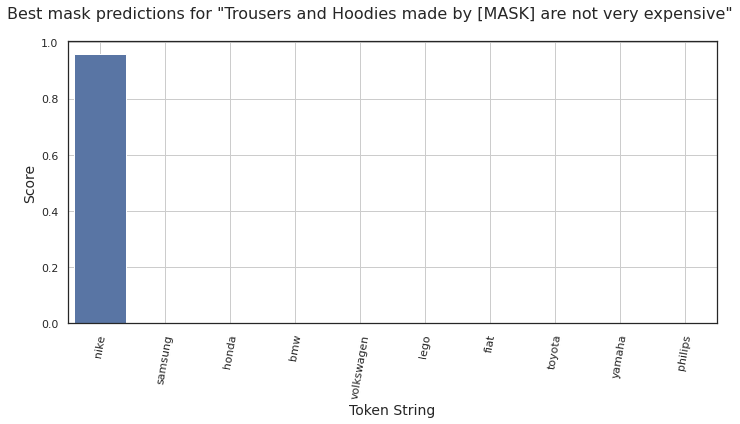

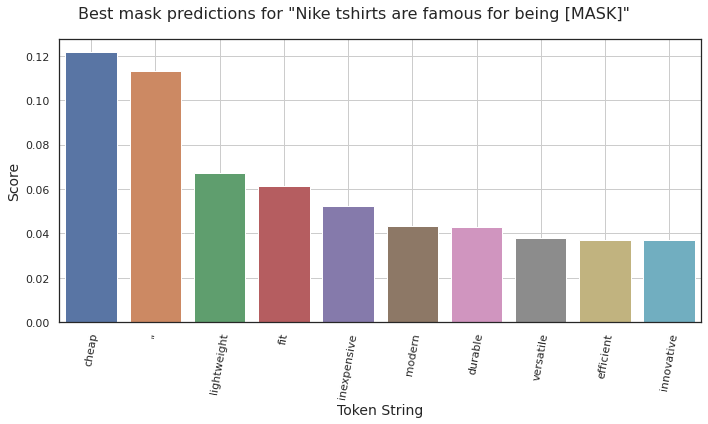

In [24]:
for index in range(len(testing_texts)):
    df = pd.DataFrame(token_scores[index])

    plt.suptitle(f'Best mask predictions for "{testing_texts[index]}"', fontsize = 16)

    ax = sns.barplot(data = df, x = 'token_str', y = 'score')
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 80, ha = 'center')
    ax.grid(True)
    ax.set_xlabel('Token String', fontsize = 14)
    ax.set_ylabel('Score', fontsize = 14)

    plt.tight_layout()
    plt.savefig(testing_texts[index].replace(' ', '-').replace('[', '').replace(']', '').lower() + '.png')
    plt.show()
    print('\n')